In [292]:
%run "preamble.ipynb"
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import numpy as np
import seaborn as sns
from graphviz import Digraph


def to_numpy(x, transpose=True):
    if isinstance(X, Variable):
        x = x.data.numpy()
    else:
        raise NotImplementedError
    if transpose:
        x = x.T
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=0)
    return x

def plot_matrix(x, annotate=True):
    ax = sns.heatmap(x, cbar=False, square=True, annot=annotate)
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    plt.show()
    
# from https://gist.github.com/dwf/292018
"""
Draws Hinton diagrams using matplotlib ( http://matplotlib.sf.net/ ).
Hinton diagrams are a handy way of visualizing weight matrices, using
colour to denote sign and area to denote magnitude.

By David Warde-Farley -- user AT cs dot toronto dot edu (user = dwf)
  with thanks to Geoffrey Hinton for providing the MATLAB code off of 
  which this is modeled.

Redistributable under the terms of the 3-clause BSD license 
(see http://www.opensource.org/licenses/bsd-license.php for details)
"""

def _blob(x, y, area, colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    plt.fill(xcorners, ycorners, colour, edgecolor=colour)

def plot_hinton(W, maxweight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """
    reenable = False
    if plt.isinteractive():
        plt.ioff()
    
    plt.clf()
    height, width = W.shape
    if not maxweight:
        maxweight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))
        
    plt.fill(np.array([0, width, width, 0]), 
             np.array([0, 0, height, height]),
             'gray')
    
    plt.axis('off')
    plt.axis('equal')
    for x in range(width):
        for y in range(height):
            _x = x+1
            _y = y+1
            w = W[y, x]
            if w > 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, w/maxweight),
                      'white')
            elif w < 0:
                _blob(_x - 0.5,
                      height - _y + 0.5, 
                      min(1, -w/maxweight), 
                      'black')
    if reenable:
        plt.ion()
        
    plt.show()
    
# from https://github.com/szagoruyko/functional-zoo/blob/master/visualize.py    
def plot_graph(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                size_str = '' if u is None else size_to_str(u.size())
                node_name = '%s\n %s' % (name, size_str)
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                name = str(type(var).__name__)
                name = name[:-8]
                dot.node(str(id(var)), name)
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

import IPython.display
IPython.display.display_latex(IPython.display.Latex(filename="macros.tex"))

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


<IPython.core.display.Javascript object>

<center>
<h1>Deep Learning for Natural Language Processing I</h1>
<h2>Word Vectors and Recurrent Neural Networks</h2>
<br>
Tim Rocktäschel<br>
<a href="https://rockt.github.com">rockt.github.com</a> <a href="mailto:tim.rocktaschel@cs.ox.ac.uk">tim.rocktaschel@cs.ox.ac.uk</a> <a href="https://twitter.com/_rockt">Twitter: @_rockt</a><br><br>
<img src="./figures/oxford.svg" width=30%><br>
2nd Int'l Summer School on Data Science, Split, Croatia<br>
27th September 2017<br>
</center>

# Sequence Tasks

<img src="./figures/proprietary/sequences.jpg" width=100%><br>
<div class=cite>[Karpathy (2015)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)</div>

# Recurrent Neural Networks

- Parameterized by cell function: 
$$f_\theta: \R^k\times\R^s \to \R^o\times\R^s$$
- Given input vector $\vec{x}_t \in \R^k$ and previous state $\vec{s}_{t-1}\in\R^s$, maps to an output vector $\vec{h}_t\in\R^o$ and next state $\vec{s}_t\in\R^s$:
$$
\vec{h}_t, \vec{s}_t = f(\vec{x}_t, \vec{s}_{t-1}). 
$$

- Given sequence of inputs
$\ls{X} = [\vec{x}_1,\ldots,\vec{x}_T]$ and a start state $\vec{s}_0$, apply cell function recursively:
$$
\rnn(f_\theta, \ls{X}, \vec{s}_0) = [f_\theta(\vec{x}_1, \vec{s}_0), \ldots, f_\theta(\vec{x}_T, \vec{s}_{T-1})]
$$

In [293]:
def rnn(cell, X, s0):
    st = s0
    H = []
    S = []
    for i in range(X.size(1)):
        ht, st = cell(X[:,i,:], st)
        H.append(ht)
        S.append(st)
    return H, S

# Fully-connected Cell

 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{h}_t &= \tanh(\mat{W}\vec{z}_t+\vec{b})\\
    \vec{s}_t &= \vec{h}_t
  \end{align}

<img src="./figures/rnn.svg" width=50%>

<div class=cite>[Elman, 1990]</div>

In [294]:
batch_size, seq_length, k_in, k_out, vocab_size = (3, 5, 2, 3, 9) 
emb = nn.Embedding(vocab_size, k_in)
I = Variable(torch.from_numpy(np.random.randint(0, vocab_size, [batch_size, seq_length])))
X = emb(I)

W = nn.Linear(k_in+k_out, k_out)
def rnn_cell(xt, st1):
    # -- [batch_size x 2*k]
    zt = torch.cat([xt, st1], dim=1)
    ht = F.tanh(W(zt))
    st = ht
    return ht, st 

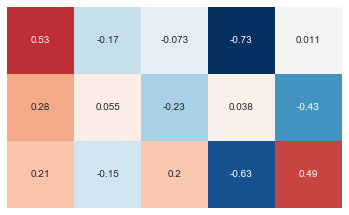

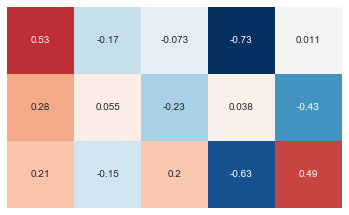

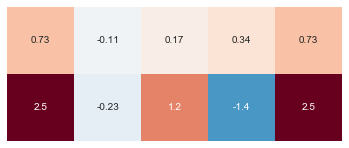

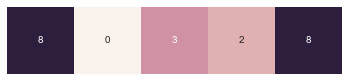

In [295]:
s0 = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(rnn_cell, X, s0)
H = torch.stack(H, dim=1)
S = torch.stack(S, dim=1)
plot_matrix(to_numpy(H[0]))
plot_matrix(to_numpy(S[0]))
plot_matrix(to_numpy(X[0]))
plot_matrix(to_numpy(I[0]))


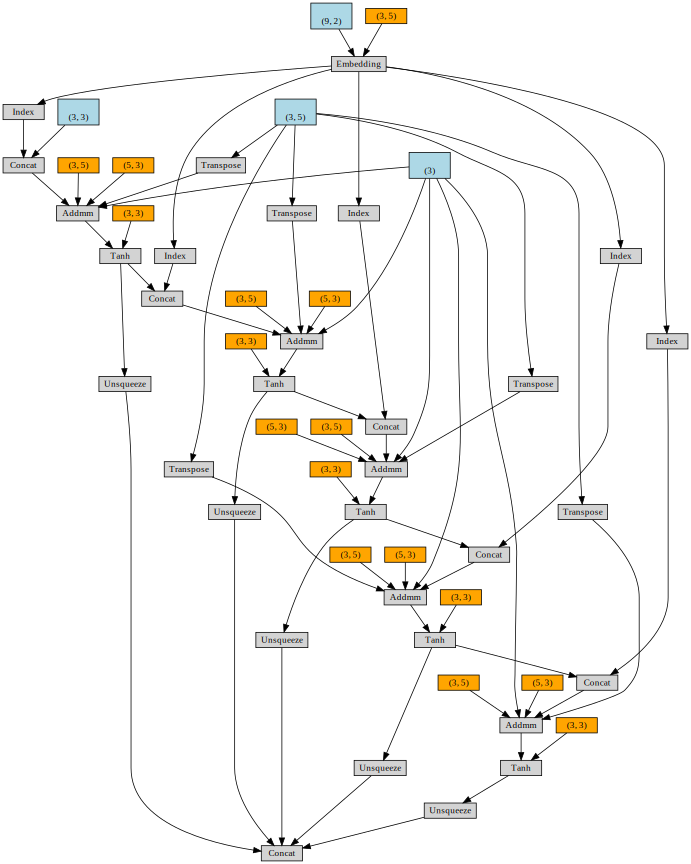

In [296]:
plot_graph(H)

# Use-case: Language Modeling

- Given a history of words $\ls{X}_{1:t-1} = [x_1, x_2, \ldots, x_{t-1}]$, predict the next word
$$
p(x_t \ | \ \ls{X}_{1:t-1})
$$
- Can be predicted from output vector $\vec{h}_t$ of an RNN at time step $t$
$$
p(x_t \ |\ \ls{X}_{1:t-1}) = \softmax(\mat{V}\vec{h}_t+\vec{b}) = \frac{\exp(\mat{V}\vec{h}_t+\vec{b})}{\sum_{j}\exp(\mat{V}\vec{h}_t+\vec{b})}
$$
where $\mat{V}\in\R^{|\set{V}|\times k}$ is an embedding matrix of all words in the vocabulary $\set{V}$ 
- Cross-entropy loss for target word $\vec{y}$ (one-hot encoding) given predicted probability distribution $\vec{\hat y} = p(x_t \ |\ \ls{X}_{1:t-1}) $
$$
L(\vec{y}, \vec{\hat y}) = - \sum_i\vec{y}_i\log(\vec{\hat y}_i)
$$



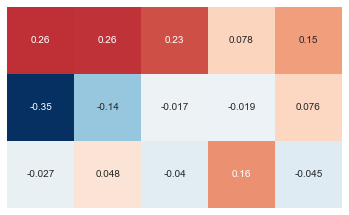

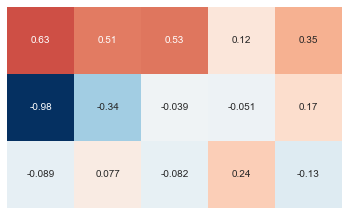

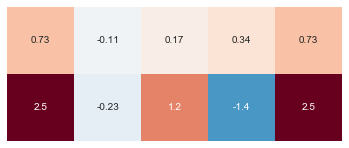

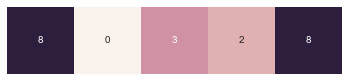

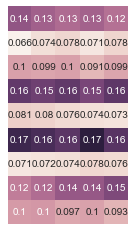

Variable containing:
 2.2186
[torch.FloatTensor of size 1]

In [299]:
s0h = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
s0c = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(lstm_cell, X, (s0h, s0c))
H = torch.stack(H, dim=1)
S = torch.stack([s[1] for s in S], dim=1)
plot_matrix(to_numpy(H[0]))
plot_matrix(to_numpy(S[0]))
plot_matrix(to_numpy(X[0]))
plot_matrix(to_numpy(I[0]))

project = nn.Linear(k_out, vocab_size)

log_scores = project(H).view(-1, vocab_size)
p = nn.Softmax()(log_scores).view(batch_size, -1, vocab_size)
plot_matrix(to_numpy(p[0]))

target = Variable(torch.LongTensor(batch_size * seq_length).random_(vocab_size))

loss = nn.CrossEntropyLoss()(log_scores, target)
loss

# Back-propagation Through Time (BPTT)

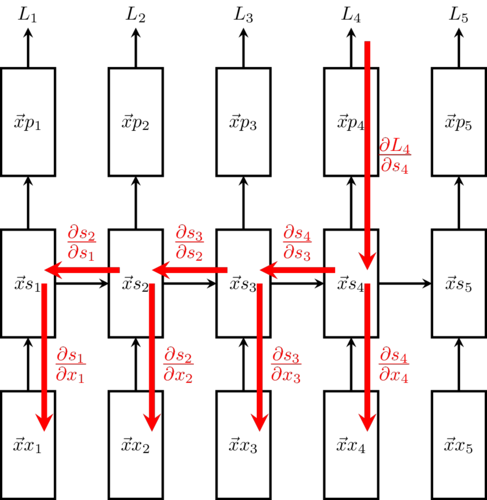

In [298]:
%%tikz --scale 1.0 -s 500,500 -l arrows
\foreach \x in {0,2,...,8} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \foreach \l/\label in {0/x,1/s,2/p} {
        \draw[very thick] (\x, \l*3) rectangle (\x+1, \l*3+2);
        \node[] at (\x+0.5, \l*3+1) {$\vec{x}\label_{\xlabel}$};
    }
    \node[] at (\x+0.5, 9) {$L_{\xlabel}$};
    \draw[very thick, -stealth] (\x+0.5, 2) -- (\x+0.5, 3);
    \draw[very thick, -stealth] (\x+0.5, 5) -- (\x+0.5, 6);
    \draw[very thick, -stealth] (\x+0.5, 8) -- (\x+0.5, 8.75);
}
\foreach \x in {0,2,...,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[very thick, -stealth] (\x+1, 4) -- (\x+2, 4);
    \draw[line width=3pt, -stealth, red] (\x+0.8, 4) -- 
  node[pos=0.55, anchor=west] {\Large$\frac{\partial s_\xlabel}{\partial x_\xlabel}$} (\x+0.8, 1.25);
}
\draw[line width=3pt, -stealth, red] (6.8, 8.5) -- 
  node[midway, anchor=west] {\Large$\frac{\partial L_4}{\partial s_4}$} (6.8, 4.25);
\draw[line width=3pt, -stealth, red] (6.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_4}{\partial s_3}$} (4.8, 4.25);
\draw[line width=3pt, -stealth, red] (4.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_3}{\partial s_2}$} (2.8, 4.25);
\draw[line width=3pt, -stealth, red] (2.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_2}{\partial s_1}$} (0.8, 4.25);

- RNN cell reminder
$$
 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{h}_t &= \tanh(\mat{W}\vec{z}_t+\vec{b})\\
    \vec{s}_t &= \vec{h}_t
  \end{align}
$$

- Gradient calculation w.r.t. input embedding
$$
\begin{align}
\frac{\partial L_4}{\partial \vec{x}_1} &= 
\frac{\partial L_4}{\partial \vec{s}_4}\frac{\partial \vec{s}_4}{\partial \vec{x}_1} = \frac{\partial L_4}{\partial \vec{s}_4}\frac{\partial \vec{s}_4}{\partial \vec{s}_3}\frac{\partial \vec{s}_3}{\partial \vec{s}_2}\frac{\partial \vec{s}_2}{\partial \vec{s}_1}\frac{\partial \vec{s}_1}{\partial \vec{x}_1}
\end{align}
$$
- Gradient calculation w.r.t. transition matrix
$$
\begin{align}
\frac{\partial L_4}{\partial \mat{W}} &= \sum_{i=0}^4 \frac{\partial \vec{s}_i}{\partial \mat{W}}
\end{align}
$$
...summing up contributions from every timestep!

$\toref$

# Truncated Back-propagation Through Time (TBPTT)

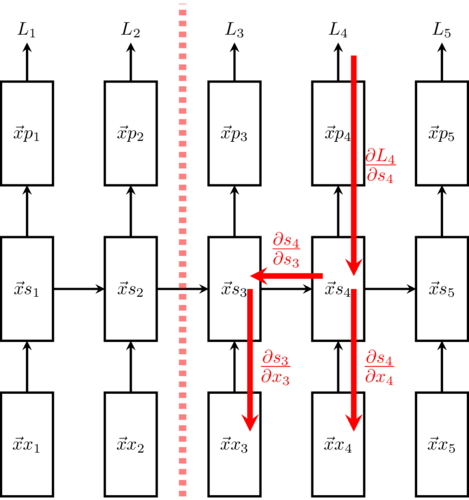

In [307]:
%%tikz --scale 1.0 -s 500,500 -l arrows
\foreach \x in {0,2,...,8} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \foreach \l/\label in {0/x,1/s,2/p} {
        \draw[very thick] (\x, \l*3) rectangle (\x+1, \l*3+2);
        \node[] at (\x+0.5, \l*3+1) {$\vec{x}\label_{\xlabel}$};
    }
    \node[] at (\x+0.5, 9) {$L_{\xlabel}$};
    \draw[very thick, -stealth] (\x+0.5, 2) -- (\x+0.5, 3);
    \draw[very thick, -stealth] (\x+0.5, 5) -- (\x+0.5, 6);
    \draw[very thick, -stealth] (\x+0.5, 8) -- (\x+0.5, 8.75);
}
\foreach \x in {0,2,...,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[very thick, -stealth] (\x+1, 4) -- (\x+2, 4);
}
\foreach \x in {4,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[line width=3pt, -stealth, red] (\x+0.8, 4) -- node[pos=0.55, anchor=west] {\Large$\frac{\partial s_\xlabel}{\partial x_\xlabel}$} (\x+0.8, 1.25);
}
\draw[line width=3pt, -stealth, red] (6.8, 8.5) -- 
  node[midway, anchor=west] {\Large$\frac{\partial L_4}{\partial s_4}$} (6.8, 4.25);
\draw[line width=3pt, -stealth, red] (6.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_4}{\partial s_3}$} (4.8, 4.25);
\draw[line width=4pt, red, opacity=0.5, dashed] (3.5,0) -- (3.5,9.);

$\toref$

# Long Short-term Memory (LSTM)

  \begin{align}
    \left[{
      \begin{array}{*{20}c}
        \vec{h}_{t-1} \\
        \vec{c}_{t-1}
      \end{array} }
    \right] &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{i}_t &= \sigma(\mat{W}^i\vec{z}_t+\vec{b}^i) \label{input}\\
    \vec{f}_t &= \sigma(\mat{W}^f\vec{z}_t+\vec{b}^f) \label{forget}\\
    \vec{o}_t &= \sigma(\mat{W}^o\vec{z}_t+\vec{b}^o) \label{output}\\
    \vec{c}_t &= \vec{f}_t \odot \vec{c}_{t-1} + \vec{i}_t \odot
    \tanh(\mat{W}^c\vec{z}_t+\vec{b}^c)\\
    \vec{h}_t &= \vec{o}_t \odot \tanh(\vec{c}_t)\\
    \vec{s}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{h}_t \\
        \vec{c}_t
      \end{array} }
    \right]
  \end{align}

<img src="./figures/lstm.svg" width=80%>

<div class=cite>[Hochreiter and Schmidhuber, 1997]</div>

In [198]:
Wi = nn.Linear(k_in+k_out, k_out)
Wf = nn.Linear(k_in+k_out, k_out)
Wo = nn.Linear(k_in+k_out, k_out)
Wc = nn.Linear(k_in+k_out, k_out)
def lstm_cell(xt, st1):
    ht1, ct1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    it = F.sigmoid(Wi(zt))
    ft = F.sigmoid(Wf(zt))
    ot = F.sigmoid(Wo(zt))
    ct = ft * ct1 + it * F.tanh(Wc(zt))
    ht = ot * F.tanh(ct)
    st = (ht, ct)
    return ht, st 

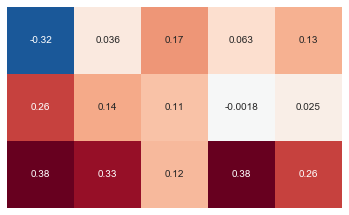

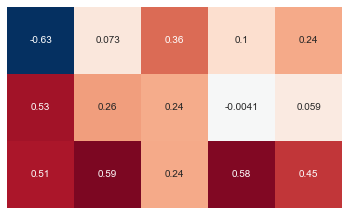

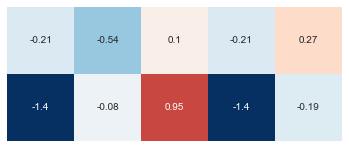

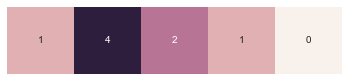

In [199]:
s0h = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
s0c = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(lstm_cell, X, (s0h, s0c))
H = torch.stack(H, dim=1)
S = torch.stack([s[1] for s in S], dim=1)
plot_matrix(to_numpy(H[0]))
plot_matrix(to_numpy(S[0]))
plot_matrix(to_numpy(X[0]))
plot_matrix(to_numpy(I[0]))


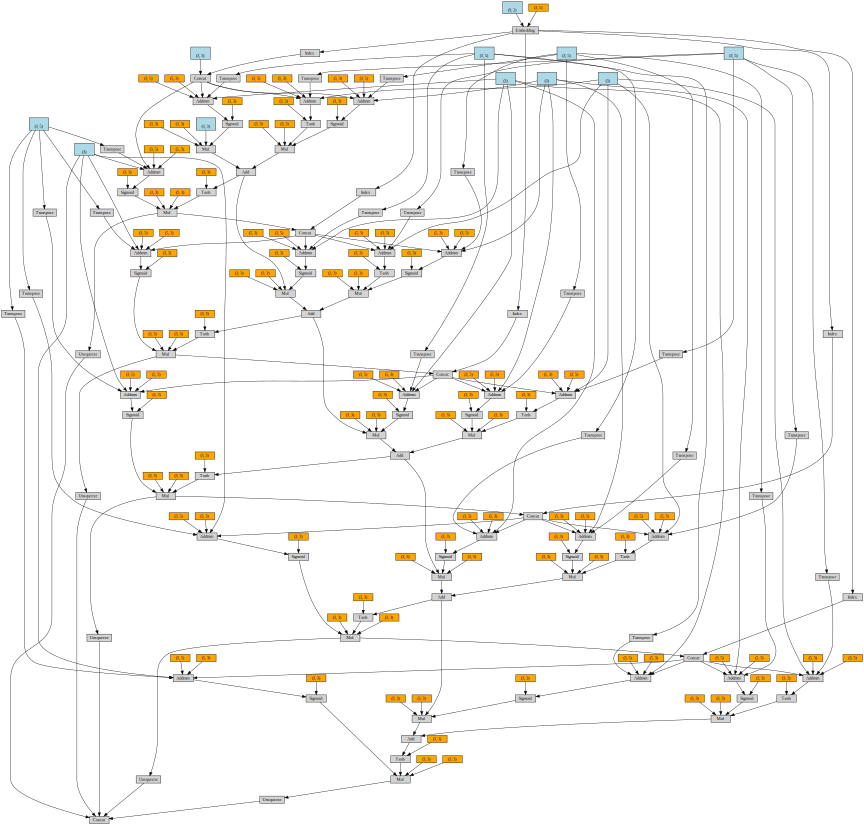

In [200]:
plot_graph(H)

# Gated Recurrent Unit (GRU)

 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{u}_t &= \sigma(\mat{W}^u\vec{z}_t+\vec{b}^u)\\
    \vec{r}_t &= \sigma(\mat{W}^r\vec{z}_t+\vec{b}^r)\\
    \vec{n}_t &= \tanh(\mat{W}^x\vec{x}_t + \vec{b}^x) + \vec{r}_t \odot (\mat{W}^h\vec{h}_{t-1} + \vec{b}^h)\\
    \vec{h}_t &= \vec{u}_t \odot \vec{h}_{t-1} + (1 - \vec{u}_t) \odot \vec{n}_t\\
    \vec{s}_t &= \vec{h}_t
  \end{align}

In [201]:
Wu = nn.Linear(k_in+k_out, k_out)
Wr = nn.Linear(k_in+k_out, k_out)
Wx = nn.Linear(k_in, k_out)
Wh = nn.Linear(k_out, k_out)
def gru_cell(xt, st1):
    ht1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    ut = F.sigmoid(Wi(zt))
    rt = F.sigmoid(Wf(zt))
    nt = F.tanh(Wx(xt)) + rt * (Wh(ht1))
    ht = ut * ht1 + (1-ut) * nt
    st = ht
    return ht, st 

<div class=cite>[Cho et al., 2014]</div>

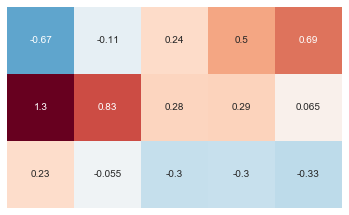

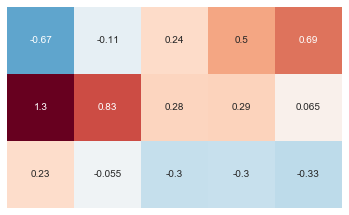

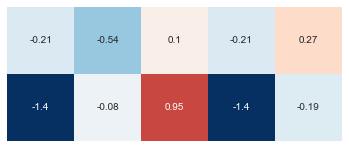

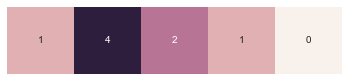

In [202]:
s0 = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(gru_cell, X, s0)
H = torch.stack(H, dim=1)
S = torch.stack(S, dim=1)
plot_matrix(to_numpy(H[0]))
plot_matrix(to_numpy(S[0]))
plot_matrix(to_numpy(X[0]))
plot_matrix(to_numpy(I[0]))


# Quasi-recurrent Neural Networks (QRNNs)

<div class=cite>[Bradbury et al., 2017]</div>

# Bidirectional RNNs

# Use-case: Stance Detection

<img src="./figures/bidirectional.svg" width=100%>

<div class=cite>[Augenstein et al., 2016]</div>

# Character RNNs

# Use-case: Sequence Tagging
- Given a input sequence $\ls{X} = [x_1, x_2, \ldots, x_N]$, predict label sequence $\ls{Y} = [y_1, y_2, \ldots, y_N]$
$$
p(\ls{Y}\ |\ \ls{X})
$$
- $y_t$ be predicted from output vector $\vec{h}_t$ of an RNN at time step $t$
$$
p(y_t \ |\ \ls{X}) = \softmax(\mat{V}\vec{h}_t+\vec{b})
$$
- Cross-entropy loss
$$
- \sum_i\vec{y}_i\log(\vec{\hat y}_i)
$$

# Recurrent Dropout

<div class=cite><a href="http://papers.nips.cc/paper/6241-a-theoretically-grounded-application-of-dropout-in-recurrent-neural-networks.pdf">[Gal and Ghahramani, 2016]</a></div>

# Further Reading
- [Goldberg. The Unreasonable Effectiveness of Character-level Language Models. 2015.](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)
- [Karpathy. The Unreasonable Effectiveness of Recurrent Neural Networks. 2015.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Merity. Explaining and illustrating orthogonal initialization for recurrent neural networks. 2016](http://smerity.com/articles/2016/orthogonal_init.html)